The whole pipeline is taken from this [awesome blog](https://greydanus.github.io/2020/03/10/lagrangian-nns/)

## Necessary imports

We'll need JAX, as it provides suitable simple and effective functionality for automatic differentiation

In [1]:
!pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -U -q Pillow moviepy proglog

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.6/143.6 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 2.6 MB/s eta 0:00:00
  Using cached nv

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit

from jax.example_libraries import stax
from jax.example_libraries import optimizers

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy.editor import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


## System utils

### Lagrangian

Inputs:
- `q` - coordinates ($\theta_1$ and $\theta_2$)
- `q_dot` - velocities (angular velocities $\omega_1$ and $\omega_2$)
- `m1`, `m2` - masses of the endings of two pendulums
- `l1`, `l2` - lengths of the two rods
- `g` - gravitational acceleration


The thing is, that just as we are used to working with Newton's law $F=ma$ to derive motion equations of the system, we can do so with Lagrangian and the Euler-Lagrange equations

So, the lagrangian is calculated as the difference of kinetic and potential energies.

The kinetic energy can be calculated as
$$
\begin{split}  T &= \frac{1}{2}m_1 v_1^2 + \frac{1}{2}m_2 v_2^2 \\[6px] &= \frac{1}{2}m_1(\dot{x}_1^2 + \dot{y}_1^2) + \frac{1}{2}m_2(\dot{x}_2^2 + \dot{y}_2^2) \\[6px] &= \frac{1}{2}m_1 l_1^2 \dot{\theta}_1^2 + \frac{1}{2}m_2\left[l_1^2 \dot{\theta}_1^2 + l_2^2 \dot{\theta}_2^2 + 2 l_1 l_2 \dot{\theta}_1\dot{\theta}_2 \cos(\theta_1 - \theta_2)\right]  \end{split}
$$

Note that here we transite from the cartesian coordinates to just angle of the rod (and the length, which remains constant) \

We can write the same for the potential energy, which is:

$$
\begin{split}  V &= m_1 g y_1 + m_2 g y_2 \\[6px] &= -m_1 g l_1 \cos\theta_1 - m_2 g (l_1 \cos\theta_1 + l_2 \cos\theta_2) \\[6px] &= -(m_1 + m_2) g l_1 \cos\theta_1 - m_2 g l_2\cos\theta_2  \end{split}
$$

Therefore, the mentioned Lagrangian of our system can be written as
$$
\begin{split}  L =\frac{1}{2}(m_1 + m_2) l_1^2 \dot{\theta}_1^2 &+ \frac{1}{2}m_2 l_2^2 \dot{\theta}_2^2 + m_2 l_1 l_2 \dot{\theta}_1\dot{\theta}_2 \cos(\theta_1 - \theta_2) \\[6px] &+ (m_1 + m_2) g l_1 \cos\theta_1 + m_2 g l_2\cos\theta_2  \end{split}
$$

In [4]:
def lagrangian(q, q_dot, m1, m2, l1, l2, g):
    """
    Compute the Lagrangian for a double pendulum system.

    Parameters:
    - q: Array of generalized coordinates [theta1, theta2]
    - q_dot: Array of generalized velocities [omega1, omega2]
    - m1, m2: Masses of the two pendulums
    - l1, l2: Lengths of the two pendulum rods
    - g: Gravitational acceleration

    Returns:
    - Scalar value of the Lagrangian (L = T - V)
    """
    t1, t2 = q
    w1, w2 = q_dot
    # Kinetic Energy (T)
    # Kinetic energy of the first pendulum + kinetic energy of the second pendulum
    T = 0.5 * m1 * (l1 * w1)**2 + \
        0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 + 2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))

    # Potential Energy (V)
    # Potential energy of the first pendulum + potential energy of the second pendulum
    y1 = -l1 * jnp.cos(t1)
    y2 = y1 - l2 * jnp.cos(t2)
    V = m1 * g * y1 + m2 * g * y2

    # Lagrangian (L = T - V)
    L = T - V

    return L

In [5]:
m1, m2 = 1.0, 1.0   # masses
l1, l2 = 1.0, 1.0   # lengths
g = 9.81            # gravitational acceleration

# Example state of the system
q = jnp.array([jnp.pi/4, jnp.pi/3])      # angles in radians
q_dot = jnp.array([0.1, 0.1])            # angular velocities in radians/sec

L_value = lagrangian(q, q_dot, m1, m2, l1, l2, g)
print("Lagrangian:", L_value)

Lagrangian: 18.803095


Now we will need a function, that will help us generate data and then test the predictions that our model will make.

This is the function, that analytically solves the motion equations for our system

You can see the whole derviation [here](https://dassencio.org/33)

The Lagrangian-Euler equation which we will use for solving the motion equations of our system is similar to the Newton's second law, as it states that the Force is the Rate of change of Momentum. ($F = \dot{P}$)

So, for the Lagrangian this equation is

$$
\frac{d}{dt}\left(\frac{∂L}{∂\dot{\theta_i}}\right) - \frac{\partial L}{\partial \theta_i} = 0
$$

Which can be rewritten as

$$
\frac{dp_{\theta_i}}{dt}-\frac{∂L}{∂\theta_i}=0
$$

Now, let's define our momentums as the partial derivatives of the lagrangian with respect to angular velocities ($\dot{\theta_1}$ and $\dot{\theta_2}$)

$$
\begin{alignat}{99}   p_{\theta_1} &= \frac{∂L}{∂\dot{\theta}_1} = (m_1 + m_2) l_1^2 \dot{\theta}_1 + m_2 l_1 l_2 \dot{\theta}_2\cos(\theta_1 - \theta_2) \\[6px] p_{\theta_2} &= \frac{∂ L}{∂\dot{\theta}_2} = m_2 l_2^2 \dot{\theta}_2 + m_2 l_1 l_2 \dot{\theta}_1\cos(\theta_1 - \theta_2)    \end{alignat}
$$

After we put these momenta into the lagrange-euler equation and rearrange a little bit, we will get the following equation:
$$
\ddot{\theta_1}+\alpha_1(\theta_1, \theta_2)\ddot{\theta_2} = f_1(\theta_1, \theta_2, \dot{\theta_1}, \dot{\theta_2}) \\
\ddot{\theta_2}+\alpha_2(\theta_1, \theta_2)\ddot{\theta_2} = f_2(\theta_1, \theta_2, \dot{\theta_1}, \dot{\theta_2})
$$

where

$$
\alpha_1(\theta_1,\theta_2) = \frac{l_2}{l_1}\left(\frac{m_2}{m_1 + m_2}\right)\cos(\theta_1 - \theta_2) \\
\alpha_2(\theta_1,\theta_2) = \frac{l_1}{l_2}\cos(\theta_1-\theta_2)
$$

and

$$
f_1(\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) = - \frac{l_2}{l_1}\left(\frac{m_2}{m_1 + m_2}\right) \dot{\theta}_2^2\sin(\theta_1 - \theta_2) - \frac{g}{l_1} \sin\theta_1  \\
f_2(\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) = \frac{l_1}{l_2}\dot{\theta}_1^2\sin(\theta_1 - \theta_2) - \frac{g}{l_2} \sin\theta_2
$$

and now we can rewrite it into the matrix form, to have a single equation:

$$
A \begin{pmatrix}\ddot{\theta_1}\\\ddot{\theta_2} \end{pmatrix} =  \begin{pmatrix}1 & \alpha_1 \\ \alpha_2 & 1 \end{pmatrix}  \begin{pmatrix}\ddot{\theta_1}\\\ddot{\theta_2} \end{pmatrix} =  \begin{pmatrix}f_1\\f_2 \end{pmatrix}
$$

Note, that the matrix $A$ is invertible, and by multiplying it on the right on both sides, we can get the motion equation of the system, which will be the first order differential equation on the variables $\theta_1, \theta_2, \omega_1, \omega_2$


$$
\displaystyle\frac{d}{dt}
\left( \begin{matrix} \theta_1 \\[1pt] \theta_2 \\[1pt] \omega_1 \\[1pt] \omega_1 \end{matrix} \right)
=
\left( \begin{matrix} \omega_1 \\ \omega_2 \\ g_1(\theta_1,\theta_2,\omega_1,\omega_2)
\\ g_2(\theta_1,\theta_2,\omega_1,\omega_2) \end{matrix} \right)
$$

where
$$
g_1 = \frac{f_1 - \alpha_1 f_2}{1 - \alpha_1\alpha_2}
\quad\quad
g_2 = \frac{-\alpha_2 f_1 + f_2}{1 - \alpha_1\alpha_2}
$$


Unfortunately, this differential equation cannot be solved analytically. But we can approximate it numerically via Runge-Kutta method, for example

In [6]:
def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
  t1, t2, w1, w2 = state
  a1 = (l2 / l1) * (m2 / (m1 + m2)) * jnp.cos(t1 - t2)
  a2 = (l1 / l2) * jnp.cos(t1 - t2)
  f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - \
      (g / l1) * jnp.sin(t1)
  f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2) - (g / l2) * jnp.sin(t2)
  g1 = (f1 - a1 * f2) / (1 - a1 * a2)
  g2 = (f2 - a2 * f1) / (1 - a1 * a2)
  return jnp.stack([w1, w2, g1, g2])

Plus, our lagrangian is a Neural Network now, so we can't analytically solve the motion equation using its output. So we better do it numerically

Firstly, we will write down the lagrangian-euler equation, and try to get $\ddot{q}$ from it

$$
\begin{align}
\frac{d}{dt} \frac{\partial L}{\partial \dot q_j} &= \frac{\partial L}{\partial q_j} & \text{write down the Euler-Lagrange equation} \quad (1)\\
\frac{d}{dt} \nabla_{\dot q} L &= \nabla_{q} L & \text{switch to vector notation} \quad (2)\\
\end{align}
$$

Here we just put the Euler-Lagrangian equation (Remember, similar to $F=ma$) and rewrote it in the vector form, so that we can deal simultaneously with both angles in our system


Now, we can apply product rule to expand time-derivatives
$$
\begin{align}
(\nabla_{\dot q}\nabla_{\dot q}^{\top}L)\ddot q + (\nabla_{q}\nabla_{\dot q}^{\top}L) \dot q &= \nabla_q L & \text{expand the time derivative }\frac{d}{dt} \quad (3)\\
\end{align}
$$
The first term here is just the Hessian of the Lagrangian with respect to $\dot{q}$ (we can treat it as separate variable). We can interpret it, as how the velocities affect each other.

The second term $(\nabla_{q}\nabla_{\dot q}^{\top}L) \dot q$ represents how changes in position affect the rate of change of momentum.

Now, using pseudoinverse of the hessian, we can isolate the accelerations $\ddot{q}$ and get the equation for them


$$
\begin{align}
\ddot q &= (\nabla_{\dot q}\nabla_{\dot q}^{\top}L)^{-1}[\nabla_q L - (\nabla_{q}\nabla_{\dot q}^{\top}L)\dot q] & \text{use a matrix inverse to solve for } \ddot q \quad (4)\\
\end{align}
$$


To compute the gradient and hessian of the lagrangian, we will make use of JAX automatic differentiation tools

In [7]:
def equation_of_motion(lagrangian, state, t=None):
  """
    Computes the time derivatives of the system's state using the Euler-Lagrange equations derived from the given Lagrangian.

    Parameters:
    - lagrangian: A function that takes generalized coordinates q and generalized velocities q_t and returns the scalar Lagrangian value.
    - state: A flat array containing both the generalized coordinates (q) and velocities (q_t).
    - t: Optional time parameter, not used in the computation here but required for compatibility with ODE solvers.

    Returns:
    - A concatenated array of velocities and accelerations representing the time derivatives of the state.
  """
  q, q_t = jnp.split(state, 2)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

def solve_lagrangian(lagrangian, initial_state, **kwargs):
  """
    Solves the Lagrangian system's equations of motion using numerical integration.

    Parameters:
    - lagrangian: The Lagrangian function of the system, as defined above.
    - initial_state: The initial conditions for the state of the system (generalized coordinates and velocities).
    - **kwargs: Additional arguments to pass to the ODE solver (such as time span, tolerances).

    Returns:
    - The trajectory of the state over time, as computed by the ODE solver.
  """
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)

Here, we also define some helper functions for our system

In [8]:
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
  """
    Solves the double pendulum dynamics using a Lagrangian defined by given parameters and numerical integration.

    Parameters:
    - initial_state: The initial state of the system, containing angles and angular velocities.
    - times: A 1D array of time points at which to solve the system.
    - m1, m2: Masses of the first and second pendulum segments.
    - l1, l2: Lengths of the first and second pendulum rods.
    - g: Gravitational acceleration constant.

    Returns:
    - The trajectory of the system over the specified times.
  """
  L = partial(lagrangian, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
  return solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)


@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
  """
    Numerically integrates the double pendulum's motion based on analytical equations of motion.

    Parameters:
    - initial_state: The initial conditions of the system, typically [theta1, theta2, omega1, omega2].
    - times: An array of time points for which the solution is computed.

    Returns:
    - A trajectory of the state vectors over time.
  """
  return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

def normalize_dp(state):
  """
    Normalizes the angles in the state vector to the range [-pi, pi].

    Parameters:
    - state: The state vector of the system, expected to contain angles and angular velocities.

    Returns:
    - The state vector with normalized angles.
  """
  return jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

def rk4_step(f, x, t, h):
  """
    Performs a single step of the Runge-Kutta 4th order integration method.

    Parameters:
    - f: The derivative function which computes derivatives of the state.
    - x: The current state of the system.
    - t: The current time.
    - h: The step size for the integration.

    Returns:
    - The estimated state of the system at the next time step.
  """
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

## Generate data

In [9]:
time_step = 0.01
N = 1500
analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=time_step)))

# Train
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
t = np.arange(N, dtype=np.float32)
x_train = jax.device_get(solve_analytical(x0, t))
xt_train = jax.device_get(jax.vmap(f_analytical)(x_train))
y_train = jax.device_get(analytical_step(x_train))

# Test
# we add noise here to simulate real world pertrubations
noise = np.random.RandomState(0).randn(x0.size)

t_test = np.arange(N, 2*N, dtype=np.float32)
x_test = jax.device_get(solve_analytical(x0, t_test))
xt_test = jax.device_get(jax.vmap(f_analytical)(x_test))
y_test = jax.device_get(analytical_step(x_test))

### Visualizing the data

Before visualizing the data, we need to normalize the angles bewtween the `[-π, π]` range

Then, we compute a normalized representation of the velocity vector's angle in the plane defined by the angular velocities of the two pendulums. The result is a value between 0 and 1, where 0 corresponds to -π and 1 to π.

After that we map the normalized angle to a color in a simple RGB format where the green channel intensity is proportional to the angle and the red channel intensity is its inverse. This creates a visual gradient that reflects the magnitude and direction of the velocity.

On the plot the vectors indicate the direction and magnitude of the velocities.


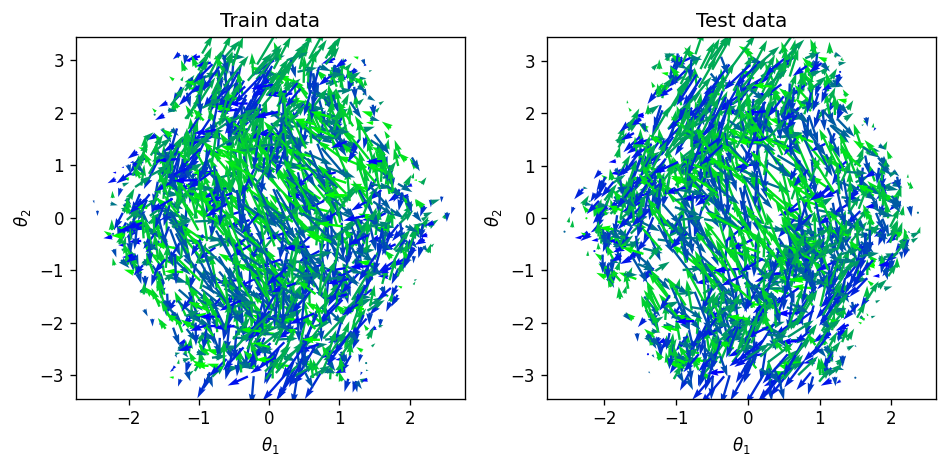

In [10]:
# preprocess
train_vis = jax.vmap(normalize_dp)(x_train)
test_vis = jax.vmap(normalize_dp)(x_test)

vel_angle = lambda data:  (np.arctan2(data[:,3], data[:,2]) / np.pi + 1)/2
vel_color = lambda vangle: np.stack( [np.zeros_like(vangle), vangle, 1-vangle]).T
train_colors = vel_color(vel_angle(train_vis))
test_colors = vel_color(vel_angle(test_vis))

# plot
SCALE = 80 ; WIDTH = 0.006
plt.figure(figsize=[8,4], dpi=120)
plt.subplot(1,2,1)
plt.title("Train data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
plt.quiver(*train_vis.T, color=train_colors, scale=SCALE, width=WIDTH)

plt.subplot(1,2,2)
plt.title("Test data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
plt.quiver(*test_vis.T, color=test_colors, scale=SCALE, width=WIDTH)

plt.tight_layout() ; plt.show()

## Model and loss definition

In [11]:
def learned_lagrangian(params):
  """
    Returns a Lagrangian function parameterized by a neural network.

    Parameters:
    - params: The parameters (weights and biases) of the neural network.

    Returns:
    - A function that computes the Lagrangian given the generalized coordinates and velocities.
  """
  def lagrangian(q, q_t):
    assert q.shape == (2,)
    state = normalize_dp(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return lagrangian


@jax.jit
def loss(params, batch, time_step=None):
  """
    Computes the mean squared error (MSE) between the predicted states and target states.

    Parameters:
    - params: Parameters of the neural network defining the Lagrangian.
    - batch: A tuple of (state, targets) where 'state' includes the current states of the system and 'targets' includes the desired next states.
    - time_step: The time step to use for simulation, if None, uses default time step in dynamics calculation.

    Returns:
    - The MSE loss.
  """
  state, targets = batch
  if time_step is not None:
    f = partial(equation_of_motion, learned_lagrangian(params))
    preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
  else:
    preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
  return jnp.mean((preds - targets) ** 2)


init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(1),
)

### Define optimization and data

In [12]:
@jax.jit
def update_timestep(i, opt_state, batch):
  """
    Updates the parameters of the model for a specific timestep during training.

    Parameters:
    - i: The iteration number in the training loop.
    - opt_state: The current state of the optimizer.
    - batch: The batch of data (state and target values) used for training.

    Returns:
    - Updated optimizer state after applying the gradient update.
  """
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, time_step), opt_state)

@jax.jit
def update_derivative(i, opt_state, batch):
  """
    Updates the parameters of the model based on the derivative of the loss function without specifying a time step.

    Parameters:
    - i: The iteration number in the training loop.
    - opt_state: The current state of the optimizer.
    - batch: The batch of data (state and target values) used for training.

    Returns:
    - Updated optimizer state after applying the gradient update.
  """
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

x_train = jax.device_put(jax.vmap(normalize_dp)(x_train))
y_train = jax.device_put(y_train)

x_test = jax.device_put(jax.vmap(normalize_dp)(x_test))
y_test = jax.device_put(y_test)

## Train

For training we use Adam optimizer with a learning rate that decays in stages. The learning rate starts at 0.001, then decays to 0.0003 after one-third of the training, and finally to 0.0001 after two-thirds.

In [13]:
%%time

rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 4))

# numbers in comments denote stephan's settings
batch_size = 100
test_every = 100
num_batches = 1500

train_losses = []
test_losses = []

# adam w learn rate decay
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                         [1e-3, 3e-4, 1e-4]))
opt_state = opt_init(init_params)

for iteration in range(batch_size*num_batches + 1):
  if iteration % batch_size == 0:
    params = get_params(opt_state)
    train_loss = loss(params, (x_train, xt_train))
    train_losses.append(train_loss)
    test_loss = loss(params, (x_test, xt_test))
    test_losses.append(test_loss)
    if iteration % (batch_size*test_every) == 0:
      print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")
  opt_state = update_derivative(iteration, opt_state, (x_train, xt_train))

params = get_params(opt_state)

iteration=0, train_loss=1011.783142, test_loss=707.065002
iteration=10000, train_loss=226.364349, test_loss=214.273880
iteration=20000, train_loss=169.130600, test_loss=153.859055
iteration=30000, train_loss=4.162549, test_loss=3.981005
iteration=40000, train_loss=0.638966, test_loss=0.651520
iteration=50000, train_loss=0.240620, test_loss=0.233004
iteration=60000, train_loss=0.053758, test_loss=0.069708
iteration=70000, train_loss=0.043108, test_loss=0.053891
iteration=80000, train_loss=0.044879, test_loss=0.052717
iteration=90000, train_loss=0.054735, test_loss=0.057856
iteration=100000, train_loss=0.021872, test_loss=0.029736
iteration=110000, train_loss=0.013915, test_loss=0.020555
iteration=120000, train_loss=0.059015, test_loss=0.057318
iteration=130000, train_loss=0.017152, test_loss=0.020934
iteration=140000, train_loss=0.009187, test_loss=0.014178
iteration=150000, train_loss=0.008386, test_loss=0.013137
CPU times: user 4min 38s, sys: 2min 59s, total: 7min 38s
Wall time: 7min 

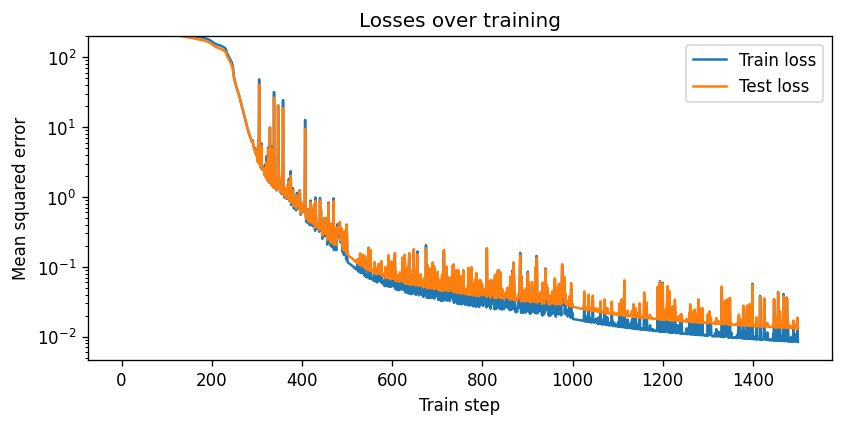

In [14]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.yscale('log')
plt.ylim(None, 200)
plt.title('Losses over training')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend() ; plt.show()

### Results compilation

Now, let's visualize the resutls

Firstly, we'll see, if the predicted and actual velocities and acceleration form 1:1 correspondence (are equal)

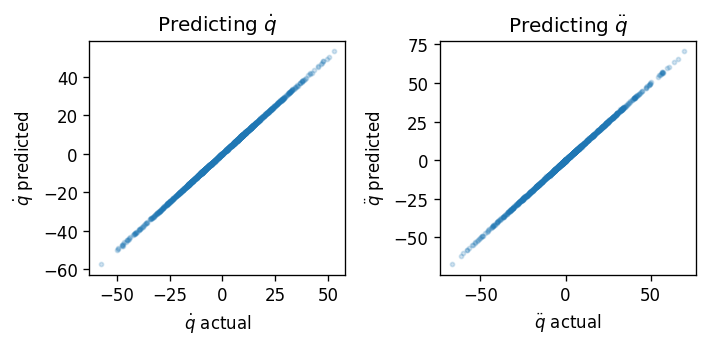

In [15]:
xt_pred = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(x_test)

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=120)
axes[0].scatter(xt_test[:, 2], xt_pred[:, 2], s=6, alpha=0.2)
axes[0].set_title('Predicting $\dot q$')
axes[0].set_xlabel('$\dot q$ actual')
axes[0].set_ylabel('$\dot q$ predicted')
axes[1].scatter(xt_test[:, 3], xt_pred[:, 3], s=6, alpha=0.2)
axes[1].set_title('Predicting $\ddot q$')
axes[1].set_xlabel('$\ddot q$ actual')
axes[1].set_ylabel('$\ddot q$ predicted')
plt.tight_layout()

## Inference

Now, let's predict the systems motion

In [16]:
# init state
x1 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)

#timeline
t2 = np.linspace(0, 20, num=301)

%time x1_analytical = jax.device_get(solve_analytical(x1, t2))
noise_coeff_3 = 1e-3
%time x1_perturbed = jax.device_get(solve_analytical(x1 + noise_coeff_3 * noise, t2))
%time x1_model = jax.device_get(solve_lagrangian(learned_lagrangian(params), x1, t=t2))

CPU times: user 579 ms, sys: 7.3 ms, total: 587 ms
Wall time: 602 ms
CPU times: user 26 ms, sys: 0 ns, total: 26 ms
Wall time: 26 ms
CPU times: user 2.5 s, sys: 18 ms, total: 2.52 s
Wall time: 2.6 s


  plt.subplot(2,1,1)



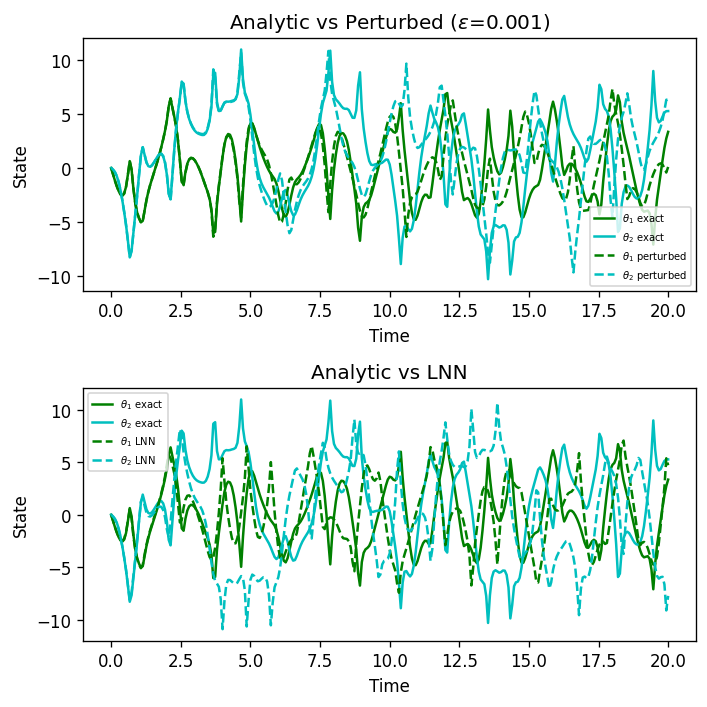

In [17]:
plt.figure(figsize=[6,6], dpi=120) ; plt.xlim(0, 20)
plt.subplot(2,1,1)
plt.title(f"Analytic vs Perturbed ($\epsilon$={noise_coeff_3})")
plt.xlabel("Time")
plt.ylabel("State")
plt.plot(t2, x1_analytical[:, 2], 'g-', label=r'$\theta_1$ exact')
plt.plot(t2, x1_analytical[:, 3], 'c-', label=r'$\theta_2$ exact')
plt.plot(t2, x1_perturbed[:, 2], 'g--', label=r'$\theta_1$ perturbed')
plt.plot(t2, x1_perturbed[:, 3], 'c--', label=r'$\theta_2$ perturbed')
plt.legend(fontsize=6)

plt.subplot(2,1,2)
plt.title("Analytic vs LNN")
plt.xlabel("Time")
plt.ylabel("State")
plt.plot(t2, x1_analytical[:, 2], 'g-', label=r'$\theta_1$ exact')
plt.plot(t2, x1_analytical[:, 3], 'c-', label=r'$\theta_2$ exact')
plt.plot(t2, x1_model[:, 2], 'g--', label=r'$\theta_1$ LNN')
plt.plot(t2, x1_model[:, 3], 'c--', label=r'$\theta_2$ LNN')
plt.legend(fontsize=6)

plt.tight_layout()
plt.show()

## Video of pendulum

Now we can intuitively checl results of our prediction by visualizing the pendulum movement

In [18]:
def make_plot(i, cart_coords, l1, l2, max_trail=30, trail_segments=20, r = 0.05):
  """
    Plots the double pendulum configuration at a given time step and optionally saves it to a file.

    Parameters:
    - i: Index of the current time step.
    - cart_coords: Cartesian coordinates of the pendulum (x1, y1, x2, y2).
    - l1, l2: Lengths of the first and second pendulum arms.
    - max_trail: The maximum number of previous positions to consider for trailing effect.
    - trail_segments: How many segments to divide the trail into (for fading effect).
    - r: Radius of the pendulum bobs.
  """
  plt.cla()

  x1, y1, x2, y2 = cart_coords
  ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k') # rods
  c0 = Circle((0, 0), r/2, fc='k', zorder=10) # anchor point
  c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10) # mass 1
  c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10) # mass 2
  ax.add_patch(c0)
  ax.add_patch(c1)
  ax.add_patch(c2)

  # Adding the trail effect for the second mass.
  s = max_trail // trail_segments
  for j in range(trail_segments):
      imin = i - (trail_segments-j)*s
      if imin < 0: continue
      imax = imin + s + 1
      alpha = (j/trail_segments)**2 # fade the trail into alpha
      ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
              lw=2, alpha=alpha)

  # Center the image on the fixed anchor point. Make axes equal.
  ax.set_xlim(-l1-l2-r, l1+l2+r)
  ax.set_ylim(-l1-l2-r, l1+l2+r)
  ax.set_aspect('equal', adjustable='box')
  plt.axis('off')
  # plt.savefig('./frames/_img{:04d}.png'.format(i//di), dpi=72)

def radial2cartesian(t1, t2, l1, l2):
  """
    Converts polar coordinates of a double pendulum into Cartesian coordinates.

    Parameters:
    - t1, t2: Angles of the first and second pendulum arms.
    - l1, l2: Lengths of the first and second pendulum arms.

    Returns:
    - Tuple of (x1, y1, x2, y2): Cartesian coordinates of both pendulum bobs.
  """
  x1 = l1 * np.sin(t1)
  y1 = -l1 * np.cos(t1)
  x2 = x1 + l2 * np.sin(t2)
  y2 = y1 - l2 * np.cos(t2)
  return x1, y1, x2, y2

def fig2image(fig):
  """
    Converts a Matplotlib figure to a 3D numpy array (image).

    Parameters:
    - fig: A Matplotlib figure object.

    Returns:
    - A numpy array representing the image of the figure.
  """
  fig.canvas.draw()
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
  image = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  return image

Now, let's make the video

0/300
1/300 2/300 3/300 4/300 5/300 6/300 7/300 8/300 9/300 10/300 11/300 12/300 13/300 14/300 15/300 16/300 17/300 18/300 19/300 20/300
21/300 22/300 23/300 24/300 25/300 26/300 27/300 28/300 29/300 30/300 31/300 32/300 33/300 34/300 35/300 36/300 37/300 38/300 39/300 40/300
41/300 42/300 43/300 44/300 45/300 46/300 47/300 48/300 49/300 50/300 51/300 52/300 53/300 54/300 55/300 56/300 57/300 58/300 59/300 60/300
61/300 62/300 63/300 64/300 65/300 66/300 67/300 68/300 69/300 70/300 71/300 72/300 73/300 74/300 75/300 76/300 77/300 78/300 79/300 80/300
81/300 82/300 83/300 84/300 85/300 86/300 87/300 88/300 89/300 90/300 91/300 92/300 93/300 94/300 95/300 96/300 97/300 98/300 99/300 100/300
101/300 102/300 103/300 104/300 105/300 106/300 107/300 108/300 109/300 110/300 111/300 112/300 113/300 114/300 115/300 116/300 117/300 118/300 119/300 120/300
121/300 122/300 123/300 124/300 125/300 126/300 127/300 128/300 129/300 130/300 131/300 132/300 133/300 134/300 135/300 136/300 137/300 138/30

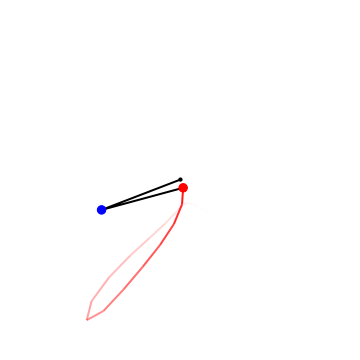

In [ ]:
L1, L2 = 1, 1
theta1, theta2 = x1_analytical[:, 0], x1_analytical[:, 1]
cart_coords = radial2cartesian(theta1, theta2, L1, L2)

fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

import warnings
warnings.filterwarnings("ignore")

images = []
di = 1
N = 300
for i in range(0, N, di):
  print(f"{i//di}/{N//di}", end='\n' if i//di%20==0 else ' ')
  make_plot(i, cart_coords, L1, L2)
  images.append(fig2image(fig))

In [ ]:
import importlib
importlib.reload(proglog)
print("True (analytical) dynamics of the double pendulum:")
proglog.default_bar_logger = partial(proglog.default_bar_logger, None)
ImageSequenceClip(images, fps=25).ipython_display()

True (analytical) dynamics of the double pendulum:


Now let's see what our LNN provided

0/300
1/300 2/300 3/300 4/300 5/300 6/300 7/300 8/300 9/300 10/300 11/300 12/300 13/300 14/300 15/300 16/300 17/300 18/300 19/300 20/300
21/300 22/300 23/300 24/300 25/300 26/300 27/300 28/300 29/300 30/300 31/300 32/300 33/300 34/300 35/300 36/300 37/300 38/300 39/300 40/300
41/300 42/300 43/300 44/300 45/300 46/300 47/300 48/300 49/300 50/300 51/300 52/300 53/300 54/300 55/300 56/300 57/300 58/300 59/300 60/300
61/300 62/300 63/300 64/300 65/300 66/300 67/300 68/300 69/300 70/300 71/300 72/300 73/300 74/300 75/300 76/300 77/300 78/300 79/300 80/300
81/300 82/300 83/300 84/300 85/300 86/300 87/300 88/300 89/300 90/300 91/300 92/300 93/300 94/300 95/300 96/300 97/300 98/300 99/300 100/300
101/300 102/300 103/300 104/300 105/300 106/300 107/300 108/300 109/300 110/300 111/300 112/300 113/300 114/300 115/300 116/300 117/300 118/300 119/300 120/300
121/300 122/300 123/300 124/300 125/300 126/300 127/300 128/300 129/300 130/300 131/300 132/300 133/300 134/300 135/300 136/300 137/300 138/30

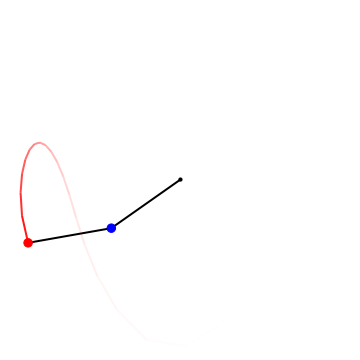

In [ ]:
L1, L2 = 1, 1
theta1, theta2 = x1_model[:, 0], x1_model[:, 1]
cart_coords = radial2cartesian(theta1, theta2, L1, L2)

fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

images = []
di = 1
N = 300
for i in range(0, N, di):
  print(f"{i//di}/{N//di}", end='\n' if i//di%20==0 else ' ')
  make_plot(i, cart_coords, L1, L2)
  images.append(fig2image(fig))

In [ ]:
import importlib
importlib.reload(proglog)
print("LNN-predicted dynamics of the double pendulum:")
proglog.default_bar_logger = partial(proglog.default_bar_logger, None)
ImageSequenceClip(images, fps=25).ipython_display()

LNN-predicted dynamics of the double pendulum:


In [ ]:
def save_movie(images, path, duration=100, loop=0, **kwargs):
  images[0].save(path, save_all=True, append_images=images[1:],
                 duration=duration, loop=loop, **kwargs)

PIL_images = [Image.fromarray(im, mode='RGB') for im in images]
save_movie(PIL_images, 'double_pend_lnn.gif')
# The movie sometimes takes a second before showing up in the file system.
import time; time.sleep(1)

from google.colab import files
files.download('double_pend_lnn.gif')

# Metrics Calculation

In [20]:
# Define the rollout error function
def rollout_error(predicted, actual):
    """
    Calculate the Rollout Error between the predicted and actual trajectories.

    Args:
    predicted (np.ndarray): Predicted trajectory.
    actual (np.ndarray): Actual trajectory.

    Returns:
    float: Rollout Error.
    """
    error = np.linalg.norm(predicted - actual, axis=1)
    norm_sum = np.linalg.norm(predicted, axis=1) + np.linalg.norm(actual, axis=1)
    return np.mean(error / norm_sum)

initial_conditions = [
    [np.radians(-20), np.radians(35), 0, 0],
    [np.radians(-50), np.radians(140), 0, 0]
]

time_points = np.linspace(0, 20, num=751)

params = get_params(opt_state)

def compute_rollout_error(initial_state):
    actual_trajectory = jax.device_get(solve_analytical(np.array(initial_state, dtype=np.float32), time_points))

    predicted_trajectory = jax.device_get(solve_lagrangian(learned_lagrangian(params), np.array(initial_state, dtype=np.float32), t=time_points))

    re_lnn = rollout_error(predicted_trajectory, actual_trajectory)
    return re_lnn


for i, init_cond in enumerate(initial_conditions):
    re_lnn = compute_rollout_error(init_cond)
    print(f'Rollout Error for LNN with initial conditions set {i+1}: {re_lnn}')

Rollout Error for LNN with initial conditions set 1: 0.48604854941368103
Rollout Error for LNN with initial conditions set 2: 0.5180467367172241
